# CS-472 Computer Vision
## Assignment 05: Particle Swarm Optimization Tracking
## By: <span style="color:orange">Ioannis Kaziales</span> ~ csdp1305
### Spring semester 2022-2023 (Due Date: 03/07/2023)

This file contains the implementation for **part B** (using PSO to track a white circle in a realistic background).
It utilizes some useful classes and functions from file `utils.py`.

If you want to see a visualization first, you can check the file `partB_demo.ipynb`

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import random
from tqdm import tqdm

from utils import *

np.random.seed(42)

In [2]:
# ~~~~~~~~~~~~~~~~~~ Some parameters about the dataset ~~~~~~~~~~~~~~~~~~
SAVE_IMGS:  bool = False    # whether to save images to disk. It will be slower if True
SAVE_PREPR: bool = False    # whether to save the preprocessed images to disk. It will be slower if True
SAVE_TXTS:  bool = True     # whether to save the estimated parameters to txt files

in_dir  = "askisi5_dataset2"    # input directory
txt_dir = "results/txt/partB"   # output directory to store the txt files with the estimated parameters
prefix  = "colorFrame_0_"       # prefix of the input files
zero_padding = 5
start_frame, end_frame = 0, 576

if not os.path.exists(txt_dir):
    os.makedirs(txt_dir)

if SAVE_IMGS:
    img_dir = "results/imgs/partB"      # output directory to store the images with the circles overlaid
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)

if SAVE_PREPR:
    prepr_dir = "results/preprocess/partB"    # output directory to store the preprocessed images
    if not os.path.exists(prepr_dir):
        os.makedirs(prepr_dir)

### 1st frame: Find the Parameters with no prior knowledge

In [3]:
img = cv2.imread(os.path.join(in_dir, f"{prefix}{str(start_frame).zfill(zero_padding)}.jpg"))
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
y_max, x_max = img.shape[:2]
max_radius = min(x_max, y_max) / 2

savefile = os.path.join(prepr_dir, f"{prefix}{str(start_frame).zfill(zero_padding)}.png") if SAVE_PREPR else None
img_preprocessed = preprocess_image(img_grey, save_filename=savefile)

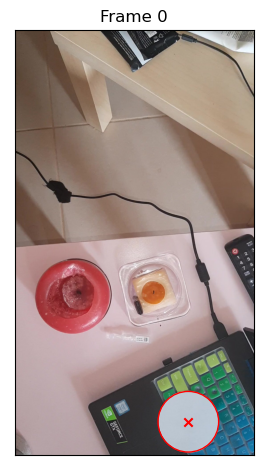

In [4]:
# PSO parameters for the first frame
num_particles = 20
max_iterations = 100
stop_iterations = 10    # stop if no improvement after 15 iterations
c1 = 2.0                # cognitive parameter
c2 = 2.0                # social parameter
w  = 0.7                # inertia weight
decay = 1.0             # decay of inertia

particles = initialize_particles(img_preprocessed, num_particles, [x_max, y_max, max_radius])
optim = ParticleSwarmOptimizer(num_particles, max_iterations, c1, c2, w, decay, stop_iterations)
best_position, best_fitness, _ = optim.optimize(img_preprocessed, particles, [x_max, y_max, max_radius])

if SAVE_TXTS:
    save_txt(os.path.join(txt_dir, f"{prefix}{start_frame}.txt"), estimated_params=best_position, type='circle')

# show the estimated circle
filename = os.path.join(img_dir, f"{prefix}{start_frame}.png") if SAVE_IMGS else None
plot_estimation(img, best_position, title=f"Frame {0}", save_filename=filename, est_type='circle', rgb=True)

x, y, r = best_position

## Some extra Plots
Essentially, we preprocess the image, run PSO on the generated preprocessed image and then return to the original image

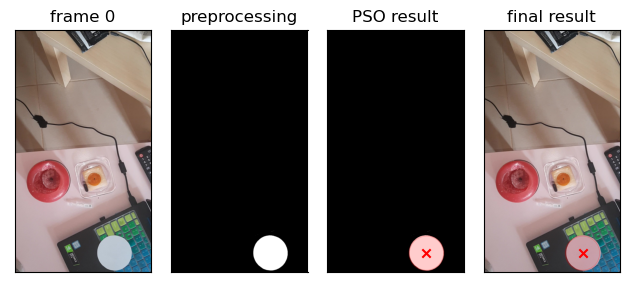

In [5]:
plt.figure()
# plot original image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"frame {start_frame}")
plt.xticks([])
plt.yticks([])
# plot the preprocessed image
plt.subplot(1, 4, 2)
plt.imshow(img_preprocessed, cmap="gray")
plt.title("preprocessing")
plt.xticks([])
plt.yticks([])
# plot the PSO result on the preprocessed image
plt.subplot(1, 4, 3)
plt.imshow(img_preprocessed, cmap="gray")
plt.scatter(x, y, color='red', marker='x')
plt.gca().add_patch(plt.Circle((x, y), r, color='red', alpha=0.2))
plt.title("PSO result")
plt.xticks([])
plt.yticks([])
# plot the final result on the original image
plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.scatter(x, y, color='red', marker='x')
plt.gca().add_patch(plt.Circle((x, y), r, color='red', alpha=0.2))
plt.title("final result")
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

### Next Frames: Use the estimated parameters from the previous frame as prior knowledge
We can use the best global position of the previous frame, $t-1$, as an initial global best position for the current frame, $t$.

Additionally, we can utilize the estimated circle radius, $\hat r_{t-1}$ to better preprocess the current frame and remove the background more effectively. We calculate the kernel size for the `opening` morphological operation in the preprocessing as:
$\lfloor 1.2 \cdot \hat r_{t-1}\rceil$

In [6]:
start_frame += 1

num_particles = 20
max_iterations = 100
stop_iterations = 6     # stop if no improvement after these iterations
c1 = 1.0                # cognitive parameter
c2 = 2.0                # social parameter
w  = 0.7                # inertia weight
decay = 0.97            # decay of inertia
high_threshold = 200    # highest threshold to try for binarization (if it fails, lower values will be tried automatically)

for i in tqdm(range(start_frame, end_frame)):
    w  = 0.7
    # load each frame
    img = cv2.imread(os.path.join(in_dir, f"{prefix}{str(i).zfill(zero_padding)}.jpg"))
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    y_max, x_max = img.shape[:2]
    max_radius = min(x_max, y_max) / 2

    # preprocess the image
    savefile = os.path.join(prepr_dir, f"{prefix}{str(i).zfill(zero_padding)}.png") if SAVE_PREPR else None
    open_size = int(1.2*best_position[2])
    threshold = high_threshold
    while True:
        img_preprocessed = preprocess_image(img_grey, threshold=threshold, open_size=open_size, save_filename=savefile)
        # if img_preprocessed is completely black, try again with lower threshold
        if np.sum(img_preprocessed) > 20:
            break
        threshold -= 10

    # run PSO on the preprocessed image
    particles = initialize_particles(img_preprocessed, num_particles, [x_max, y_max, max_radius])
    init_fitness = evaluate_fitness(img_preprocessed, best_position)
    optim = ParticleSwarmOptimizer(num_particles, max_iterations, c1, c2, w, decay, stop_iterations, best_position, init_fitness)
    best_position, best_fitness, _ = optim.optimize(img_preprocessed, particles, [x_max, y_max, max_radius])

    # save the estimated circle parameters and/or the preprocessed image
    if SAVE_TXTS:
        save_txt(os.path.join(txt_dir, f"{prefix}{i}.txt"), estimated_params=best_position, type='circle')
    if SAVE_IMGS:
        filename = os.path.join(img_dir, f"{prefix}{i}.png")
        plot_estimation(img, best_position, title=f"Frame {i}", save_filename=filename, show=False, est_type='circle', rgb=True)

100%|██████████| 575/575 [05:13<00:00,  1.84it/s]


In the next sections, you can produce videos your results (in order for it to work, you should have saved the images)

In [7]:
# uncomment to create a video from the input images of dataset2 (video 'dataset2.avi')
#make_video(in_dir, 'colorFrame_0', savepath='dataset2.avi', fps=30, extension='jpg', width=1080, height=1920, num_pad=5)

In [8]:
# uncomment to create a video from the preprocessed images of dataset2 (video 'dataset2_preprocessed.avi')
#make_video(prepr_dir, 'colorFrame_0', savepath='dataset2_preprocessed.avi', fps=30, width=1080, height=1920, num_pad=5)

In [9]:
# uncomment to create a video from the final images of dataset2 (video 'dataset2_track.avi')
#make_video(img_dir, 'colorFrame_0', savepath='dataset2_track.avi', fps=30, width=517, height=921)